In [1]:
# Import all packages needed
import numpy as np
import random
import torch

from sklearn.decomposition import PCA
from transformers import BertModel, BertTokenizerFast

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 10]


# Fix random seed for reproducibility
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


same_seeds(0)

In [2]:
contexts, questions, answers = [], [], []

# Question 1
contexts += [
    'Currently detention is one of the most common punishments in schools in the United States, the UK, Ireland, Singapore and other countries. \
            It requires the pupil to remain in school at a given time in the school day (such as lunch, recess or after school); or even to attend \
            school on a non-school day, e.g. "Saturday detention" held at some schools. During detention, students normally have to sit in a classroom \
            and do work, write lines or a punishment essay, or sit quietly.'
]
questions += ['What is a common punishment in the UK and Ireland?']
answers += ['detention']

# Question 2
contexts += [
    'Wolves are afraid of cats. Sheep are afraid of wolves. Mice are afraid of sheep. Gertrude is a mouse. Jessica is a mouse. \
            Emily is a wolf. Cats are afraid of sheep. Winona is a wolf.'
]
questions += ['What is Emily afraid of?']
answers += ['cats']

# Question 3
contexts += [
    "Nikola Tesla (Serbian Cyrillic: Никола Тесла; 10 July 1856 – 7 January 1943) was a Serbian American inventor, electrical engineer, \
            mechanical engineer, physicist, and futurist best known for his contributions to the design of the modern alternating current \
            (AC) electricity supply system."
]
questions += ["In what year was Nikola Tesla born?"]
answers += ["1856"]

In [42]:
# Choose from 1, 2, 3
QUESTION = 3

In [43]:
# model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True).eval()
model = BertModel.from_pretrained('csarron/bert-base-uncased-squad-v1', output_hidden_states=True).eval()
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('csarron/bert-base-uncased-squad-v1')

In [44]:
from pprint import pprint
# Tokenize and encode question and paragraph into model's input format
inputs = tokenizer(questions[QUESTION - 1],
                   contexts[QUESTION - 1],
                   return_tensors='pt')
pprint(inputs)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]),
 'input_ids': tensor([[  101,  1999,  2054,  2095,  2001, 24794, 26060,  2141,  1029,   102,
         24794, 26060,  1006,  6514, 15522,  1024,  1192, 10325, 23925, 14150,
         29436, 10260,  1197, 15290, 29747, 29436, 10260,  1025,  2184,  2251,
          8708,  1516,  1021,  2254,  3826,  1007,  2001,  1037,  6514,  2137,
         12235,  1010,  5992,  3992,  1010,  6228,  3992,  1010, 13702,  1010,
          1998, 11865, 20689,  2923,  2190,  2124,  2005,  2010,  5857,  2000,
          1996,  2640,  1997,  1996,  2715, 15122,  2783,  1006,  9353,  1007,
          6451,  4425,  2291,  1012,   102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
   

In [45]:
# Get the [start, end] positions of [question, context] in encoded sequence for plotting
question_start, question_end = 1, inputs['input_ids'][0].tolist().index(102) - 1
context_start, context_end = question_end + 2, len(inputs['input_ids'][0]) - 2
question_start, question_end, context_start, context_end

(1, 8, 10, 73)

In [46]:
def get_select_embedding(output, layer, tokenized_sentence, select_word_index):
    # Get selected layer's hidden state
    hidden_state = output.hidden_states[layer][0]
    # Convert select_word_index in sentence to select_token_index in tokenized sentence
    select_token_index = tokenized_sentence.word_to_tokens(
        select_word_index).start
    # Return embedding of selected word
    return hidden_state[select_token_index].numpy()

In [47]:
# Input encoded sentences into model and get outputs
with torch.no_grad():
    outputs = model(**inputs)
# Get embedding of selected word(s) in sentences. "embeddings" has shape (len(sentences), 768), where 768 is the dimension of BERT's hidden state
embeddings = [outputs.hidden_states[i] for i in range(len(outputs.hidden_states))]
torch.stack(embeddings).shape

torch.Size([13, 1, 75, 768])

In [ ]:
for i,token_id in enumerate(inputs['input_ids'][0]):
    print(token_id, tokenizer.decode(token_id))

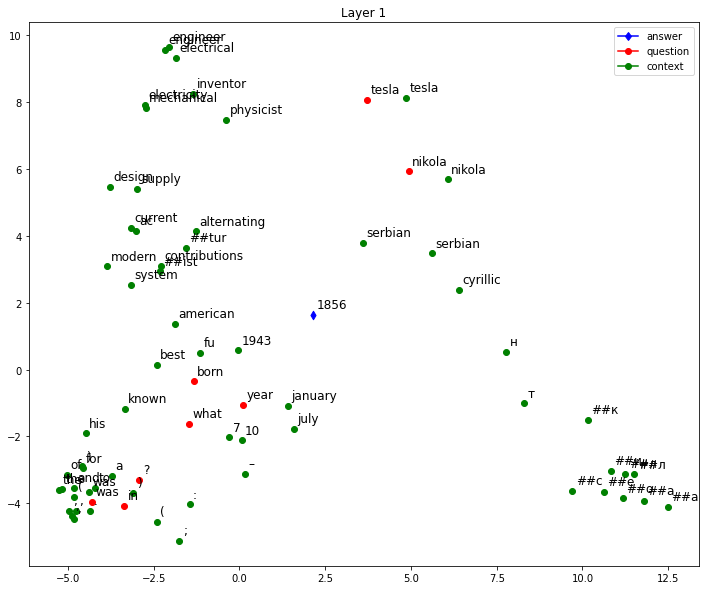

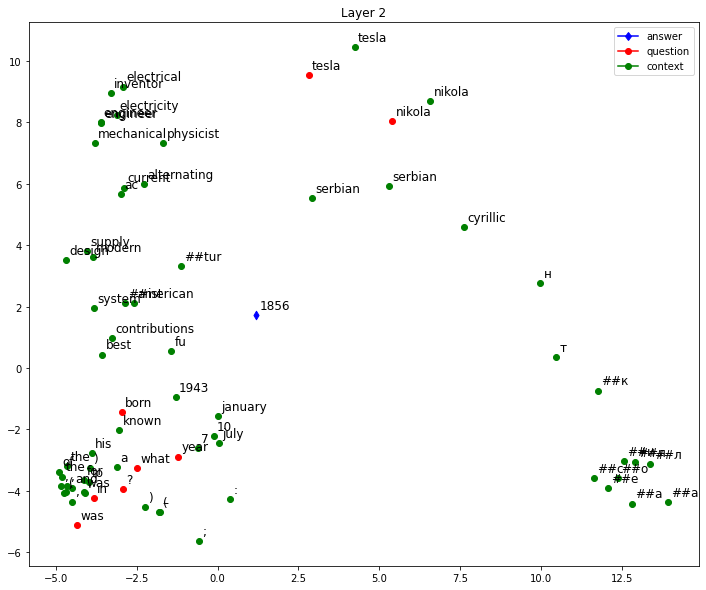

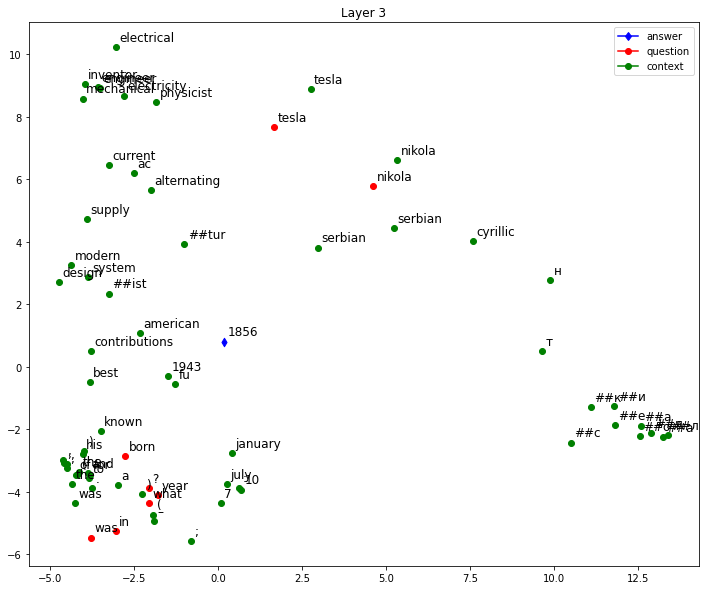

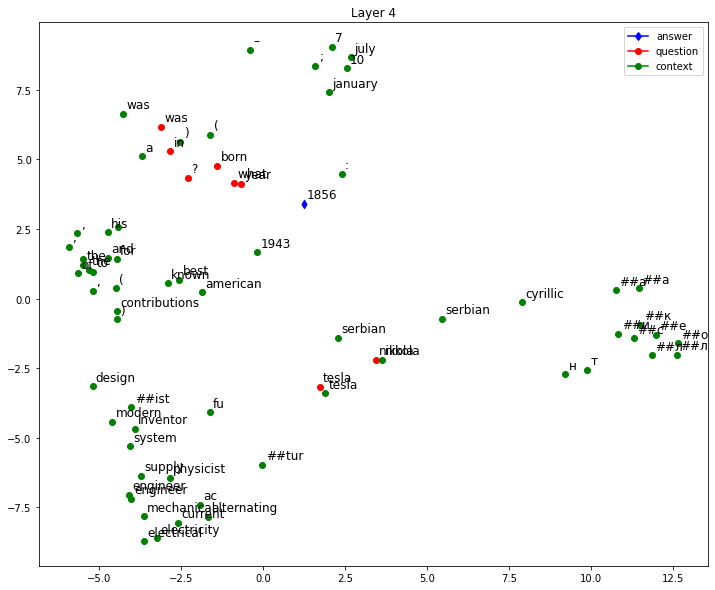

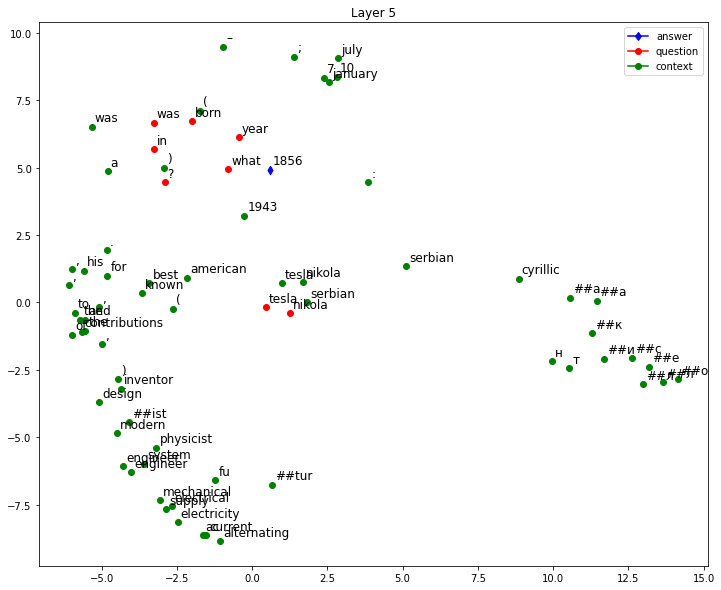

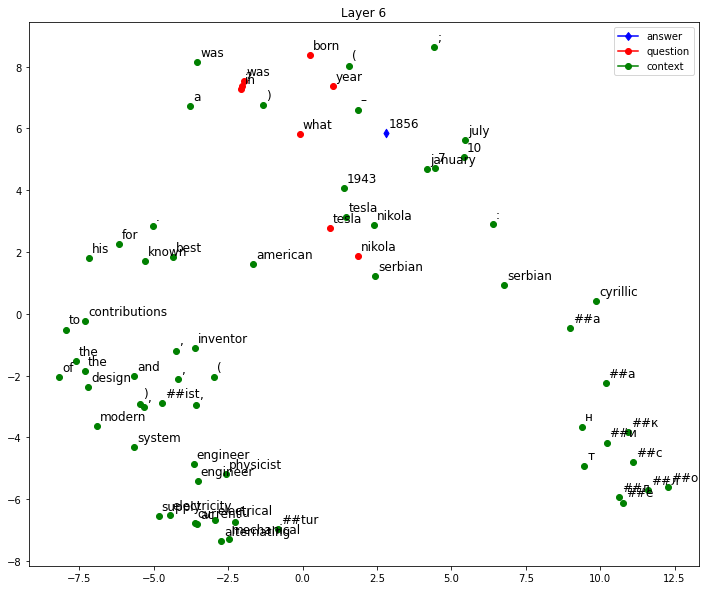

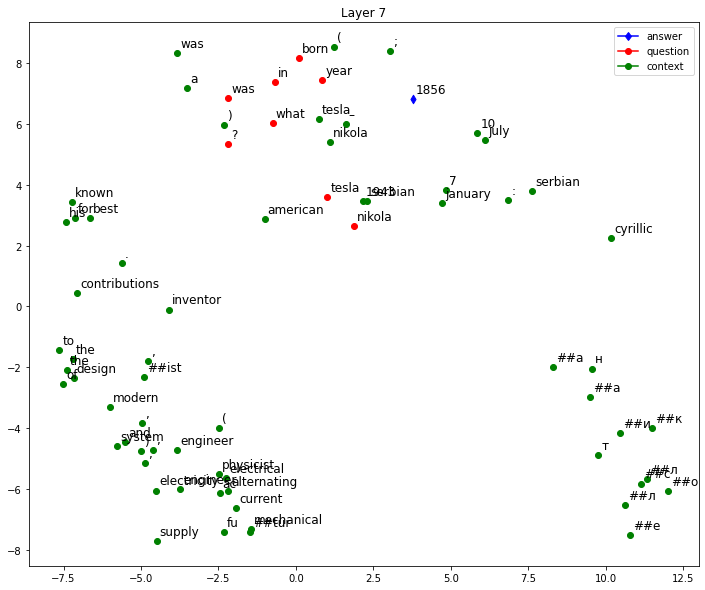

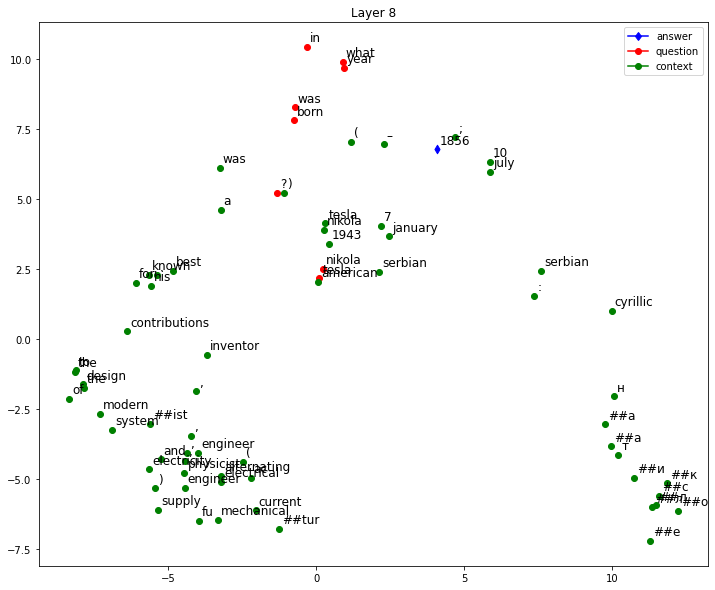

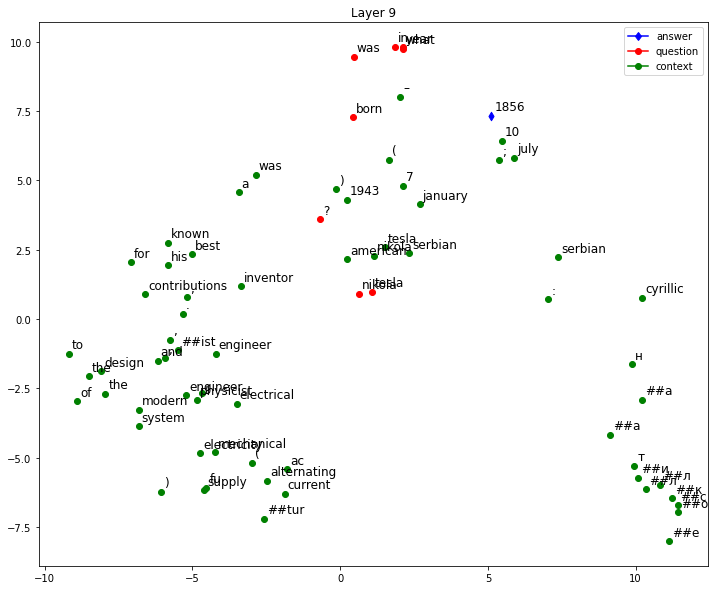

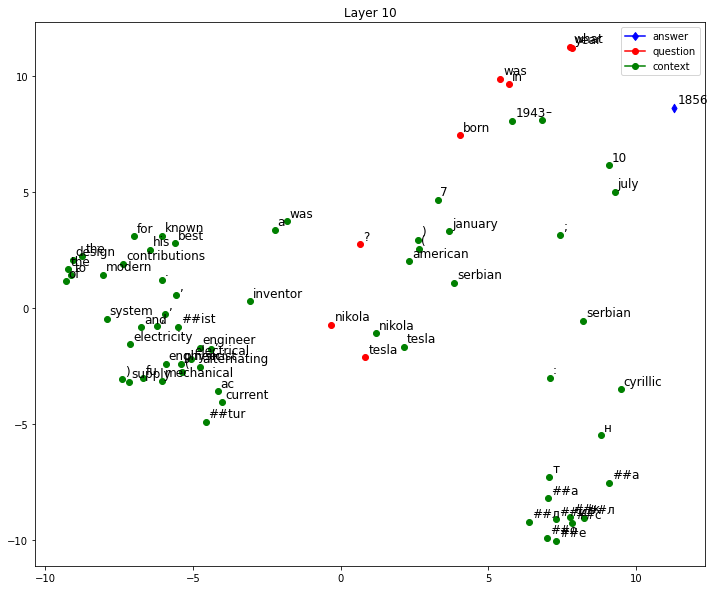

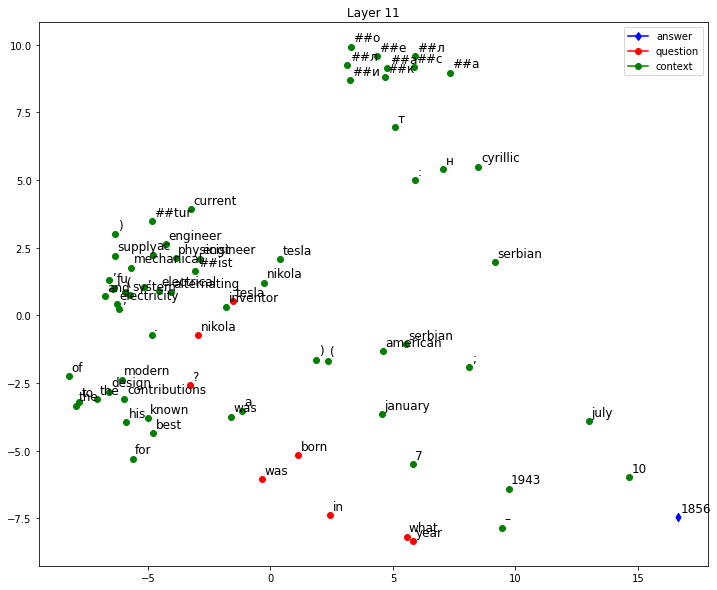

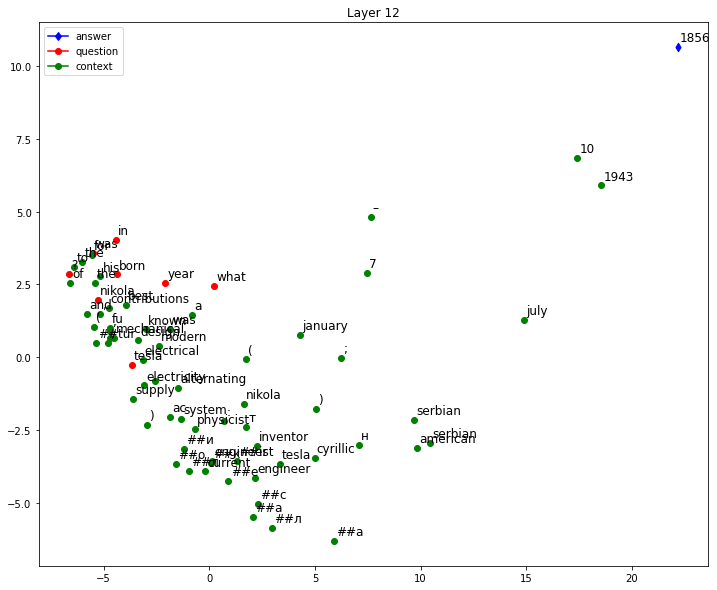

In [48]:
##### Traverse hidden state of all layers #####
# "outputs_hidden_state" is a tuple with 13 elements, the 1st element is embedding output, the other 12 elements are attention hidden states of layer 1 - 12
for layer_index, embeddings in enumerate(embeddings[1:]):

    # "embeddings" has shape [1, sequence_length, 768], where 768 is the dimension of BERT's hidden state
    # Dimension of "embeddings" is reduced from 768 to 2 using PCA (Principal Component Analysis)
    reduced_embeddings = PCA(n_components=2,
                             random_state=0).fit_transform(embeddings[0])

    ##### Draw embedding of each token #####
    for i, token_id in enumerate(inputs['input_ids'][0]):
        # Embedding has 2 dimensions, each corresponds to a point
        x, y = reduced_embeddings[i]
        # Decode token back to word
        word = tokenizer.decode(token_id)
        # Scatter points of answer, question and context in different colors
        if word in answers[QUESTION - 1].split():  # Check if word in answer
            plt.scatter(x, y, color='blue', marker='d')
        elif question_start <= i <= question_end:
            plt.scatter(x, y, color='red')
        elif context_start <= i <= context_end:
            plt.scatter(x, y, color='green')
        else:  # skip special tokens [CLS], [SEP]
            continue
        plt.text(x + 0.1, y + 0.2, word,
                 fontsize=12)  # Plot word next to its point

    # Plot "empty" points to show labels
    plt.plot([], label='answer', color='blue', marker='d')
    plt.plot([], label='question', color='red', marker='o')
    plt.plot([], label='context', color='green', marker='o')
    plt.legend(
        loc='best')  # Display the area describing the elements in the plot
    plt.title('Layer ' + str(layer_index + 1))  # Add title to the plot
    plt.show()  # Show the plot
